In [10]:
#import libraries
import pandas as pd
import json
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#load data
excel_file_path = '../01-Data/00-GoogleData/180905_venue_data.xlsx'
json_file_path = '../01-Data/00-GoogleData/180914_venues_final.json'
shapefile_path = '../01-Data/01-Shapefiles/Hydrography_Polygon.shp'
building_shapefile_path = '../01-Data/01-Shapefiles/boston_buildings.shp'

df_raw = pd.read_excel(excel_file_path)   #dataframe of basic location information
json_data = open(json_file_path).read()   #json data that includes populartimes data
populartimes = json.loads(json_data)         #json data that includes populartimes data
shapefile = gpd.read_file(shapefile_path) #shapefile of boston waterway
building_shapefile = gpd.read_file(building_shapefile_path)

ImportError: dlopen(/anaconda/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libiconv.2.dylib
  Referenced from: /anaconda/lib/libgdal.20.dylib
  Reason: Incompatible library version: libgdal.20.dylib requires version 9.0.0 or later, but libiconv.2.dylib provides version 8.0.0

In [3]:
df_raw = df_raw.drop_duplicates(keep='first',subset=['google_id', 'name','WeekTotals']).reset_index()

In [4]:
#Define type map for dimensionality reduction of venue type
type_maps = {'finance':['accounting','finance','atm','bank'],
             'retail':['store','clothing_store','jewelry_store','electronics_store','shoe_store','book_store','home_goods_store','furniture_store','hardware_store','pet_store','department_store','shopping_mall'],
             'transportation':['airport','bus_station','transit_station','gas_station','parking','car_rental','train_station','subway_station','light_rail_station'],
             'food':['cafe','bakery','meal_takeaway','restaurant','food','convenience_store','meal_delivery'],
             'bar':['bar','night_club','liquor_store'],
             'grocery':['grocery_or_supermarket','supermarket'],
             'health_wellness':['health','beauty_salon','hair_care','spa','gym','dentist','doctor','hospital','pharmacy','physiotherapist'],
             'automotive':['car_repair'],
             'professional_services':['lawyer','insurance_agency','general_contractor','travel_agency','real_estate_agency','veterinary_care'],
             'culture_entertainment':['art_gallery','library','museum','movie_theater','park','natural_feature','bowling_alley'],
             'religous':['church','place_of_worship','mosque','synagogue'],
             'government':['courthouse','local_government_office','fire_station','police','post_office'],
             'education':['school','university'],
             'lodging':['lodging'],
             'other':['point_of_interest','establishment','moving_company','storage','premise','bicycle_store','florist','cemetery','laundry','painter','locksmith','plumber','roofing_contractor','car_dealer','car_wash','electrician']}

In [5]:
#Convert venue type, which is currently a string, 
#to a list of words for each record
from keras.preprocessing.text import text_to_word_sequence

df_processed = df_raw.copy(deep=True)

for i in range(len(df_raw)):
    a = text_to_word_sequence(df_raw.iloc[i]['venue_type'], 
                              filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', 
                              lower=False, 
                              split=' ')
    b = []
    for word in a:  
        c = text_to_word_sequence(word, 
                                  filters="'", 
                                  lower=False, 
                                  split=' ')
        b.append(c[0])
    df_processed.at[i,'venue_type'] = b
df_processed.head(1)

Using TensorFlow backend.


,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,...,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood,visit_venue_density,walk_score,transit_score,bike_score,transit_summary,average_walk_score
0,0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"[accounting, lawyer, finance, point_of_interes...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333


In [6]:
#map venue_type to one value based on type_map dictionary
type_list = []
for i in range(len(df_processed)):
    vals_to_map = df_processed.iloc[i]['venue_type']    
    for item in vals_to_map:
        for key in list(type_maps.keys()):            
            list_to_check = type_maps[key]            
            if item in list_to_check:
                type_list.append(key)
                break
        if item in list_to_check:
            break
df_processed['mapped_venue_type'] = pd.DataFrame({'type':type_list})
print(len(type_list))
df_processed.to_excel('../01-Data/00-GoogleData/180914_venue_data_processed.xlsx')
df_processed.head()

4813


,index,name,lat,long,google_id,venue_type,Monday,Tuesday,Wednesday,Thursday,...,neighborhood,price_category,type_count_in_neighborhood,type_density_in_neighborhood,visit_venue_density,walk_score,transit_score,bike_score,transit_summary,average_walk_score
0,0,"McMahon & Associates, PC",42.352366,-71.056066,ChIJddqFA4Jw44kRHz6p3qWTs4c,"[accounting, lawyer, finance, point_of_interes...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333
1,1,"Barclay Damon, LLP",42.352321,-71.056248,ChIJD75e1YBw44kRvDZoMEj44jY,"[accounting, lawyer, finance, point_of_interes...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333
2,2,Request Health Corporation,42.351584,-71.056269,ChIJv1J9rnh644kR4hc29XVaEFg,"[accounting, finance, point_of_interest, estab...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,93.0,100.0,83.0,"78 nearby routes: 50 bus, 16 rail, 12 other",92.000000
3,3,StackUp,42.351586,-71.056323,ChIJY_v-pXh744kRub1hj4RNwkk,"[accounting, finance, point_of_interest, estab...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,93.0,100.0,83.0,"78 nearby routes: 50 bus, 16 rail, 12 other",92.000000
4,4,KPMG,42.351781,-71.056737,ChIJDaRRe4Jw44kRjXWBXIsFgj0,"[accounting, finance, point_of_interest, estab...",0,0,0,0,...,LD/SS,0,27,235.83,0.0,98.0,100.0,82.0,"78 nearby routes: 50 bus, 16 rail, 12 other",93.333333


In [7]:
#build dataframe that expands records for every hour of activity during the day
#initialize empty lists
records_lat = []
records_lng = []
records_count = []
records_hour = []
records_day = []
records_google_id = []
records_name = []
#loop through each hour of each day for every venue and store lat, long, count, and hour into a dataframe
for day in range(6):
    for hour in range(24):
        for venue in range(len(populartimes)):
            venue_lat = populartimes[venue]['coordinates']['lat']
            venue_lng = populartimes[venue]['coordinates']['lng']
            count = populartimes[venue]['populartimes'][day]['data'][hour]
            hour_of_day = hour
            day_of_week = day
            google_id = populartimes[venue]['id']
            name = populartimes[venue]['name']
            
            #append data to list
            records_lat.append(venue_lat)
            records_lng.append(venue_lng)
            records_count.append(count)
            records_hour.append(hour_of_day)
            records_day.append(day_of_week)
            records_google_id.append(google_id)
            records_name.append(name)

#save lists to dataframe            
df_time_records = pd.DataFrame({"lat":records_lat,
                                "long":records_lng,
                                "count":records_count,
                                "hour":records_hour,
                                "day":records_day,
                                "google_id":records_google_id,
                                "name":records_name})
df_time_records.head()

,lat,long,count,hour,day,google_id,name
0,42.351162,-71.045188,0,0,0,ChIJ30VlLIJw44kRk4x9eEYUtbg,PwC
1,42.374258,-71.024628,68,0,0,ChIJmd9BFjhw44kRHqSMe4nZ2a4,JetBlue Airways (Maintenance-Materials) Hangar...
2,42.374899,-71.023227,15,0,0,ChIJnfWx5Ddw44kRKctc5RWyWLg,Signature Flight Support BOS - Boston Logan In...
3,42.335894,-71.045618,0,0,0,ChIJYWYWWWN644kRKB0tazxmJ-4,ATM (Sovereign Bank)
4,42.335850,-71.045696,0,0,0,ChIJ10K12It644kRf_u0UGT3lhM,Santander Bank ATM


In [8]:
#join dataframe with venue type
df_to_join = df_processed[['google_id','mapped_venue_type']]
df_time_records_joined = df_time_records.join(df_to_join.set_index('google_id'),on='google_id')
df_time_records_joined = df_time_records_joined.drop_duplicates(keep='first',subset=['hour', 'day','google_id'])

In [9]:
from sklearn.preprocessing import MinMaxScaler
#intialize new columns
df_time_records_joined['hour_transformed'] = 0
df_time_records_joined['day_transformed'] = 0
#initialize scaler object
scaler = MinMaxScaler()
#transform hour and day
scaler.fit(df_time_records_joined[['hour','day']])
df_time_records_joined[['hour_transformed','day_transformed']] = scaler.transform(df_time_records_joined[['hour','day']])
#format day_hour column
df_time_records_joined['day_hour'] = df_time_records_joined['day']+df_time_records_joined['hour_transformed']
df_time_records_joined.head(2)

,lat,long,count,hour,day,google_id,name,mapped_venue_type,hour_transformed,day_transformed,day_hour
0,42.351162,-71.045188,0,0,0,ChIJ30VlLIJw44kRk4x9eEYUtbg,PwC,finance,0.0,0.0,0.0
1,42.374258,-71.024628,68,0,0,ChIJmd9BFjhw44kRHqSMe4nZ2a4,JetBlue Airways (Maintenance-Materials) Hangar...,transportation,0.0,0.0,0.0


In [10]:
#prepare data for kde by building a list of records 
#for each user count at each location
kde_x = []
kde_y = []

for i in range(len(df_raw)):
    lat = df_raw.iloc[i]['lat']
    lng = df_raw.iloc[i]['long']
    count = df_raw.iloc[i]['WeekTotals']
    if count > 0:
        for j in range(count):
            kde_x.append(lat)
            kde_y.append(lng)

# Visualize Data

In [12]:
#Prepare Plot Parameters
#define plot ranges
x_min = -71.1
y_min = 42.33
x_max = -71.01
y_max = 42.38

#figure size
plot_size = (12,11)

<Figure size 864x792 with 0 Axes>

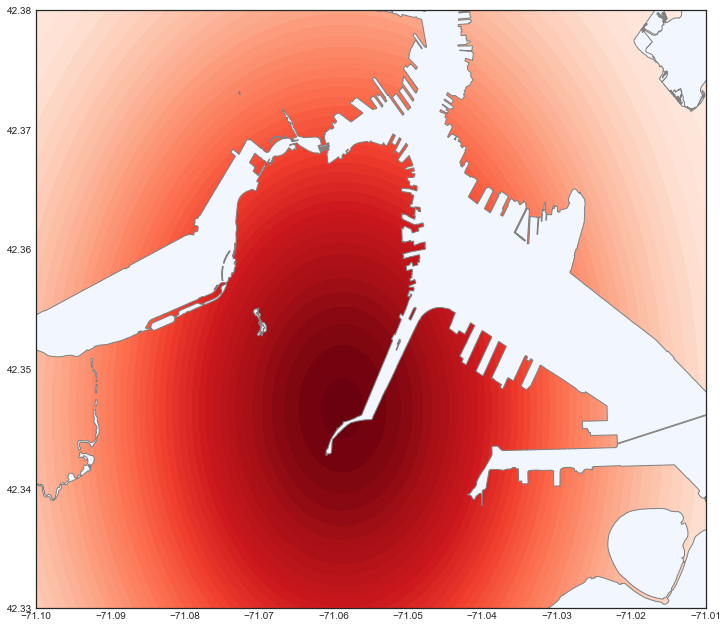

In [15]:
plt.figure(figsize=plot_size,facecolor='white')
plt.style.use('seaborn-white')

#define sample size
sample_size=10000

#sample data
X_sample = np.random.choice(kde_x,size=sample_size,replace=False)
y_sample = np.random.choice(kde_y,size=sample_size,replace=False)

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

#define plot size
f, ax = plt.subplots(1, figsize=plot_size)

#define plot ranges
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

#plot kde of user density
ax = sns.kdeplot(y_sample, X_sample, 
                 shade=True,
                 cmap="Reds",
                 shade_lowest=False,
                 n_levels=50,
                 bw=.02,
                 gridsize=1000)

#sns.jointplot(y_sample, X_sample, kind="kde", height=7, space=0)

#plot shapefile of boston buildings
#ax = building_shapefile.plot(ax=ax,alpha=1.0,edgecolor='grey',facecolor='grey')

#plot kde of  store density
'''ax = sns.kdeplot(df_processed['long'], df_processed['lat'],
                 shade=False,alpha=0.9,
                 shade_lowest=False,
                 n_levels=30,
                 linewidths=0.5,
                 bw=.001,
                 gridsize=300,
                 color="white")'''

#ax = sns.scatterplot(x='long',y='lat',data=df_processed,alpha=0.2)
#plot shapefile of boston waterway
ax = shapefile.plot(ax=ax,alpha=1,edgecolor='grey',facecolor='#f2f7ff')


#save to file
'''plt.savefig("../data_archives/plot_exports/kde/sample_{}.jpg".format(sample_size), dpi=300, edgecolor='w',
            papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)'''
#show plot
plt.show()

In [1]:
#define plot size
#plt.figure(figsize=plot_size,facecolor='white')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
%matplotlib inline

#configure shapefile projection
building_shapefile = building_shapefile.to_crs({'init': 'epsg:4326'}) 

#plot figure for each hour of the day
for i in range(7):
    for j in range(24):
        data = df_time_records_joined[df_time_records["hour"]==j]
        data = data[data["day"]==i]
        #define plot size
        f, ax = plt.subplots(1, figsize=plot_size)

        #define plot ranges
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])

        #plot shapefile of boston buildings
        ax = building_shapefile.plot(ax=ax,alpha=.05,edgecolor='#cccccc',facecolor='grey')

        #plot scatter of store locations
        ax = sns.scatterplot(x='long', y='lat', 
                             data=data,
                             s=1.5*data["count"],
                             alpha=0.25)#,
                             #hue='mapped_venue_type')

        #overlay shapefile of botston waterway
        ax = shapefile.plot(ax=ax,alpha=1.0,edgecolor='#dbdbdb',facecolor='white')
        #ax.legend_.remove()


        #save figure to file
        plt.savefig("../01-Data/02-Plots/activity_map/hour_{}_{}.jpg".format(i,j), dpi=300, facecolor='w', edgecolor='w',
                papertype=None, format=None,
                transparent=False, bbox_inches=None, pad_inches=0.1,
                frameon=None)
        #plt.show()
        plt.clf
        plt.close
        if i < 23:
            plt.cla()

NameError: name 'plt' is not defined

NameError: name 'df_processed' is not defined